<a href="https://colab.research.google.com/github/Vivek-23-Titan/Bidir-LSTM-HAR-Generation/blob/master/Human_Activity_Generation_using_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Import the libraries**##

In [ ]:
pip install --upgrade tensorflow

In [ ]:
from __future__ import print_function, division
from matplotlib import pyplot as plt
%matplotlib inline
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
import sys

!pip install -U coremltools
import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow.keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Reshape, Dropout, Concatenate, Embedding, Activation
from keras.layers import Input, LeakyReLU, BatchNormalization, ReLU, Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras import initializers
import keras_preprocessing
from keras_preprocessing import image
import keras.utils
from keras.utils import plot_model, np_utils
from keras import backend as K

import tensorflow as tf
print(tf.__version__)

##**Link the drive to obtain the WISDM Dataset**##

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from zipfile import ZipFile
file_name = '/content/drive/My Drive/WISDM_ar_v1.1_raw.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 160
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 30

keras version  2.3.1


In [ ]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('/content/drive/My Drive/WISDM_ar_v1.1_raw.zip')

##**Describe and Visualize the Dataset**##

In [ ]:
# Describe the data
show_basic_dataframe_info(df)
df.head(2384612)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.0,-1.6,1.7
1098200,19,Sitting,131623371431000,9.0,-1.5,1.7
1098201,19,Sitting,131623411592000,9.1,-1.4,1.7
1098202,19,Sitting,131623491487000,9.0,-1.5,1.7


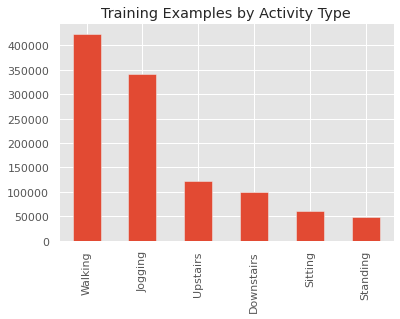

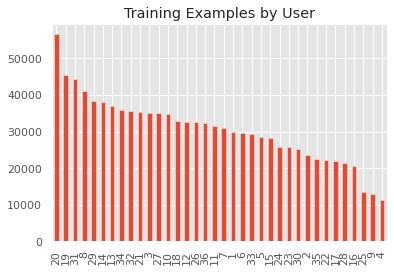

In [ ]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

In [ ]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(8, 6),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.8)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:160]
    plot_activity(activity, subset)

In [ ]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

##**Prepare the Dataset for training process**##

In [ ]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 33]
df_train = df[df['user-id'] <= 33]

In [ ]:
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [ ]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)
x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [ ]:
X1 = x_train
Y1 = y_train
X2 = x_test
Y2 = y_test

In [ ]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'testing samples')
print('y_test shape: ', y_test.shape)

x_train shape:  (33582, 160, 3)
33582 training samples
y_train shape:  (33582,)
x_test shape:  (3015, 160, 3)
3015 testing samples
y_test shape:  (3015,)


In [ ]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [ ]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_test = x_test.reshape(x_test.shape[0], input_shape)
print('x_test shape:', x_test.shape)
print('input_shape:', input_shape)

x_train shape: (33582, 480)
input_shape: 480
x_test shape: (3015, 480)
input_shape: 480


In [ ]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

y_test_hot = np_utils.to_categorical(y_test, num_classes)
print('New y_test shape: ', y_test_hot.shape)

New y_train shape:  (33582, 6)
New y_test shape:  (3015, 6)


In [ ]:
X = x_train
Y = y_train

In [ ]:
print(LABELS)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [ ]:
x_train = X
y_train = Y
print(y_train.shape)

(33582,)


In [ ]:
c = []
for i in range(len(x_train)):
  if y_train[i]==0:
    c.append(i)
    #print(i)
c = np.array(c)
print(len(c))

#Store only selective number of sequences for prediction
c = c[1:503]

3116


In [ ]:
c1 = []
for i in range(len(c)):
  c1.append(x_train[c[i]])
c1 = np.array(c1)
print(c1.shape)

(502, 480)


In [ ]:
#Reshape the array for training
c1 = np.reshape(c1, (len(c1)*480,))
c1.shape

(240960,)

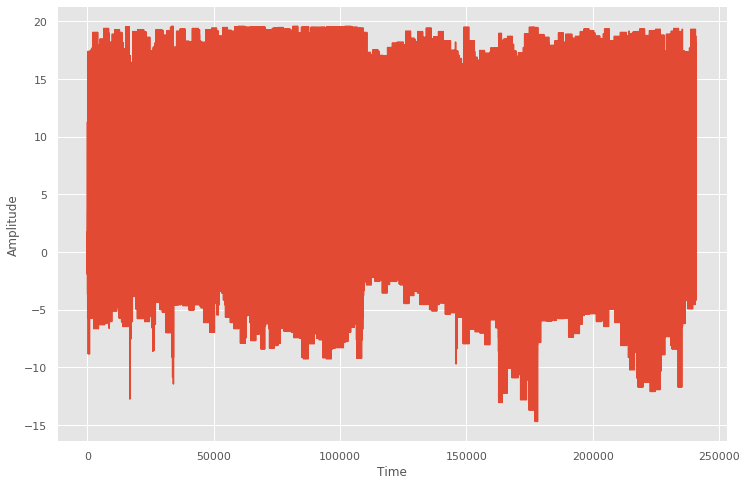

In [ ]:
#Plot the entire training activity data series
plt.figure(figsize=(12,8))

plt.plot(c1)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)

(2400,)


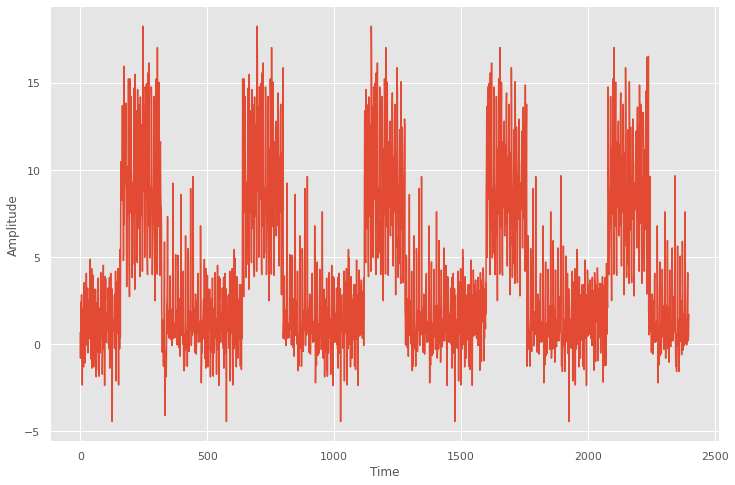

In [ ]:
#Plot of a specific number of data sequences for training
x2 = x_train[44]
x3 = x_train[45]
x4 = x_train[46]
x5 = x_train[47]
x6 = x_train[48]
x1 = np.concatenate((x2,x3,x4,x5,x6))
print(x1.shape)
plt.figure(figsize=(12,8))

plt.plot(x1)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)

##**Training Process**##

In [ ]:
#Make a time new array for timestamp values
time = np.arange(len(c1))
series = c1

In [ ]:
#Split the data for training(timestamps) and testing(data-point values)
split_time = 960
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
#Employ a window for better performance and temporal data association
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
#Plot of losses at different learning rates to choose the optimal learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#Define a sequential Bidirectional LSTM model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 9.5)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=160, callbacks=[lr_schedule])

(1e-08, 1.0, 0.0, 10.0)

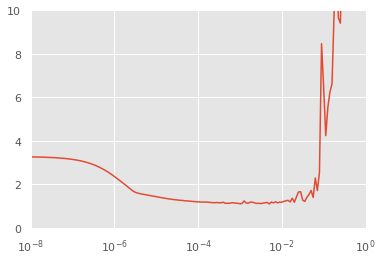

In [37]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e+0, 0, 10])

In [ ]:
#Start the training at optimal learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 20)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),metrics=["mae"])
history = model.fit(dataset, epochs=1000,verbose=1)

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
len(series)

240960

In [ ]:
time_valid.shape

(240000,)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000


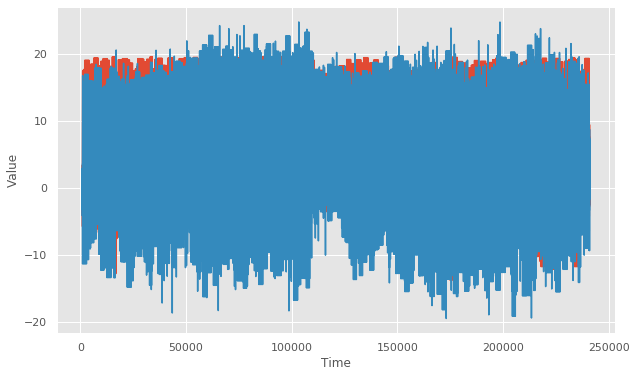

In [ ]:
#Store the predicted/Generated values in results array
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
  if time%5000 ==0:
    print(time)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

#Plot the predicted activities against original activities
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
#The overall loss metric for generated series
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.048148

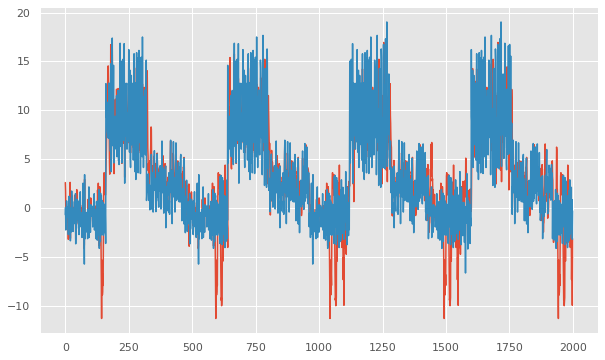

In [ ]:
#Compare the first 2000 datapoints of original and predicted values
plt.figure(figsize=(10, 6))
plt.plot(results[:2000])
plt.plot(x_valid[:2000])

In [ ]:
#Store the results in a txt file
a = results
np.savetxt('Downstairs.txt', a, fmt='%f')
#To load the file
#b = np.loadtxt('Downstairs.txt', dtype=float)